FETI - parallel implementation
-----------------------------

First step for FETI parallel implementation is to read a mesh with an existent partition.
The _Mesh_ class presented in _Amfe_ has a read method in order to do so. After reading a mesh, the _split_in_groups()_ method can be use to generate a SubMesh class.

- Mesh class - Complete list of elementes, nodes, and a data frame with Groups ID, ex. Geometry,m Physical, Partition
- SubMesh class - Subset of elementes, pointer to Mesh class.



*************************************************************
Loading gmsh-mesh from H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/2_partitions_tri_mesh.msh
Mesh H:\TUM-PC\Dokumente\Projects\AMfe\meshes/test_meshes/2_partitions_tri_mesh.msh successfully imported. 
Assign a material to a physical group.
*************************************************************
{2: <amfe.mesh.SubMesh object at 0x000001502A386CC0>, 1: <amfe.mesh.SubMesh object at 0x0000015026C84828>, 3: <amfe.mesh.SubMesh object at 0x0000015029384978>}


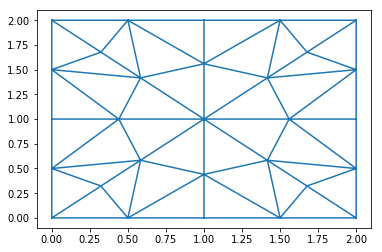

In [8]:
import sys 
import amfe
import matplotlib.pyplot as plt
import numpy as np
import scipy

# mesh file
mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_tri_mesh.msh')
domain_id = 3

# reading the mesh file
m = amfe.Mesh()
m.import_msh(mshfile)

# splitting physical grops
m.split_in_groups()

print(m.groups)

In [20]:
m.groups

{1: <amfe.mesh.SubMesh at 0x15026c84828>,
 2: <amfe.mesh.SubMesh at 0x1502a386cc0>,
 3: <amfe.mesh.SubMesh at 0x15029384978>}

In the case above, the Mesh has 3 Physical groups, 1 and 2 are boundary elementes and 3 is the physical  domain of the problem.

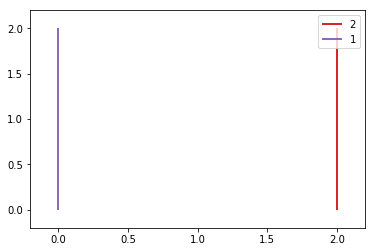

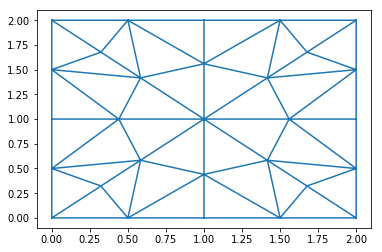

In [9]:
# plotting boundary elements
amfe.plot_boundary_1d(m)

# plotting mesh domain
amfe.plot_submesh(m.groups[domain_id])
plt.show()

Now, the SubMesh objects can be selected as problem domain. Also, the boundary condition and material type can be added to the domain, see the example below.

In [11]:
# creating material
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=0.1)

# selecting submeshes for boundary conditions
sub_neu1 = m.groups[1]
sub_neu2 = m.groups[2]

# creating Neummann boundary condition
value = 5.0E5
neu1 = amfe.boundary.Boundary(sub_neu1,value,'normal')
neu2 = amfe.boundary.Boundary(sub_neu2,value,'normal')

# selecting domain and add material and boundary condition
domain = m.groups[domain_id]
domain.set_material(my_material)
domain.append_bondary_condition(neu1)
domain.append_bondary_condition(neu2)


if the selct domain has groups with partitions ID, see [GMSH format](http://gmsh.info/doc/texinfo/gmsh.html#MSH-ASCII-file-format), then the _split_in_partitions()_ can be used to split the SubMesh Domain in subdomains.

Extract interface node from sub_1 and sub_2
Extract interface node from sub_1 and sub_3
Interface nodes from sub_3 and sub_1 already extracted
Extract interface node from sub_3 and sub_2
Interface nodes from sub_2 and sub_1 already extracted
Interface nodes from sub_2 and sub_3 already extracted


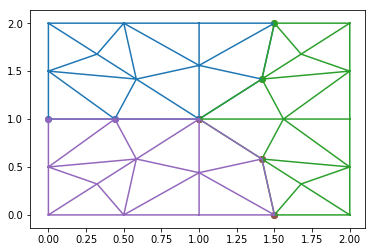

In [12]:
domain.split_in_partitions()
amfe.plot_domain(domain)
plt.show()

In [23]:
sub1 = domain.groups[1]
sub1.interface_nodes_dict

{2: [14, 16, 22], 3: [10, 16, 17]}

The split method will create a _Group_ dictionary with the subdomain SubMeshes in the domain. Besides a list of elements, each SubMesh has a dictionary, where the _keys_ are the Partition ID of the neighbor subdomain. Each element of the dictionary has a list of interface nodes. 

In [15]:
print(domain.groups)
sub1 = domain.groups[1]
print(sub1.interface_nodes_dict)

{1: <amfe.mesh.SubMesh object at 0x000001502A549208>, 3: <amfe.mesh.SubMesh object at 0x000001502A554FD0>, 2: <amfe.mesh.SubMesh object at 0x000001502A4AC160>}
{2: [14, 16, 22], 3: [10, 16, 17]}


In the case described above, the Partition ID number 1 has two neighbors with ID 2 and 3, with interface nodes 14, 16 and 22 of the interface $\Gamma^{12}$ and nodes 10, 16, and 17 in the interface $\Gamma^{13}$. The equilibrium equation for each subdomain and the interface continuity can be written as:


$$
\begin{align}
K^{(1)} u^{(1)}  = f^{(1)} + B^{T(12)} \lambda^{(12)} + B^{T(13)} \lambda^{(13)}  \\
K^{(2)} u^{(2)}  = f^{(2)} + B^{T(21)} \lambda^{(12)} + B^{T(23)} \lambda^{(23)}  \\
K^{(3)} u^{(3)}  = f^{(3)} + B^{T(31)} \lambda^{(13)} + B^{T(32)} \lambda^{(23)}  \\
B^{(12)}u^{(1)} + B^{(21)}u^{(2)}  = 0 \\
B^{(13)}u^{(1)} + B^{(31)}u^{(3)}  = 0 \\
B^{(31)}u^{(3)} + B^{(32)}u^{(2)}  = 0 \\
\end{align}
$$

Which the aditional requirement that:
$$
\begin{align}
R^{(1)} \cdot(f^{(1)} + B^{T(12)} \lambda^{(12)} + B^{T(13)} \lambda^{(13)})  = 0\\
R^{(2)} \cdot(f^{(2)} + B^{T(21)} \lambda^{(12)} + B^{T(23)} \lambda^{(23)})  = 0 \\
R^{(3)} \cdot(f^{(3)} + B^{T(31)} \lambda^{(13)} + B^{T(32)} \lambda^{(23)})  = 0 \\
\end{align}
$$

Which is equivalent to:
$$
\begin{align}
G^{(12)} \lambda^{(12)} + G^{(13)} \lambda^{(13)})  = e^{(1)}\\
G^{(21)} \lambda^{(12)} + G^{(23)} \lambda^{(23)})  = e^{(2)}\\
G^{(31)} \lambda^{(13)} + G^{(32)} \lambda^{(23)})  = e^{(3)} \\
\end{align}
$$

Where $G^{(ij)} = R^{T(i)}B^{T(i,j)}$ and $e^{(i)} = R^{(i)}f^{(i)}$. In matrix notation, the system of equation become:
$$
\begin{bmatrix}
G^{(12)} & G^{(13)} & 0 \\
G^{(21)} &  0 & G^{(23)} \\
0 & G^{(31)} & G^{(32)}
\end{bmatrix}
\begin{bmatrix}
\lambda^{(12)} \\
\lambda^{(13)} \\
\lambda^{(23)} 
\end{bmatrix}
=
\begin{bmatrix}
e^{(1)}\\
e^{(2)}\\
e^{(3)}
\end{bmatrix}
$$

In compact form the above system can be written as:

$$ G \lambda = e $$

In FETI method, the product $GG^T$ is required for both the projection operation and also for the assembly of the course grid problem. So, lets look this product in more details:
$$
\begin{bmatrix}
G^{(12)} & G^{(13)} & 0 \\
G^{(21)} &  0 & G^{(23)} \\
0 & G^{(31)} & G^{(32)}
\end{bmatrix}
\begin{bmatrix}
G^{(12)} & G^{(21)} & 0 \\
G^{(13)} &  0 & G^{(31)} \\
0 & G^{(23)} & G^{(32)}
\end{bmatrix}
$$

The first row of $GG^T$ can be written as:

$$
(1^{st} row)
\begin{bmatrix}
G^{(12)}G^{(12)} + G^{(13)}G^{(13)} & G^{(12)}G^{(21)} & G^{(13)}G^{(31)} \\
\end{bmatrix}
$$

This means, to build the i_th_ row of $GG^T$ we store $G^{(ij)}$ and receive $G^{(ji)}$ for all the neighbor subdomain.
In that way, $GG^T$ is build in parallel.